In [ ]:
!pip install neurocorgi_sdk

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from neurocorgi_sdk import NeuroCorgiNet, Head4ImageNet
from neurocorgi_sdk.transforms import ToNeuroCorgiChip

In [2]:
# If possible, set up the GPU 0 for the application
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
imagenet_path = "datasets/imagenet"
transform_val = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    ToNeuroCorgiChip()
                                    ])

validation_dataset = datasets.ImageFolder(f"{imagenet_path}/val", transform=transform_val)

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False)

In [4]:
# For this example, we use the model pretrained and quantized with the ImageNet dataset
model = NeuroCorgiNet("neurocorginet_imagenet.safetensors")
model.to(device)

NeuroCorgiNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (scale1): Scaling_FixedPoint()
  (conv1_3x3_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
  (relu1_3x3_dw): ReLU(inplace=True)
  (scale1_3x3_dw): Scaling_FixedPoint()
  (conv1_1x1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (relu1_1x1): ReLU(inplace=True)
  (scale1_1x1): Scaling_FixedPoint()
  (conv2_3x3_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
  (relu2_3x3_dw): ReLU(inplace=True)
  (scale2_3x3_dw): Scaling_FixedPoint()
  (conv2_1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (relu2_1x1): ReLU(inplace=True)
  (scale2_1x1): Scaling_FixedPoint()
  (conv3_3x3_dw): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
  (relu3_3x3_dw): ReLU(inplace=True)
  (scale3_3x3_dw): Scaling_FixedPoint()
  (conv3_1x1): Conv2d(128, 128, kernel_size=(1, 1), st

In [5]:
# We also load the head for ImageNet classification (trained by our team)
head = Head4ImageNet("neurocorginet_head_imagenet.safetensors")
head.to(device)

Head4ImageNet(
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=1024, out_features=1000, bias=True)
)

In [6]:
pbar = tqdm(validation_loader)
val_correct = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(pbar):
        inputs = inputs.to(device)
        labels = labels.to(device)

        div4, div8, div16, div32 = model(inputs)
        out = head(div32)

        _, val_preds = torch.max(out, 1)
        val_correct += torch.sum(val_preds == labels.data)
        accuracy = (val_correct / i) * 100

        pbar.set_description_str(f"Torch model - ImageNet test accuracy: {accuracy:.2f}%")

Torch model - ImageNet test accuracy: 70.16%: 100%|██████████| 50000/50000 [22:23<00:00, 37.20it/s]


In [10]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image / 255
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    return image

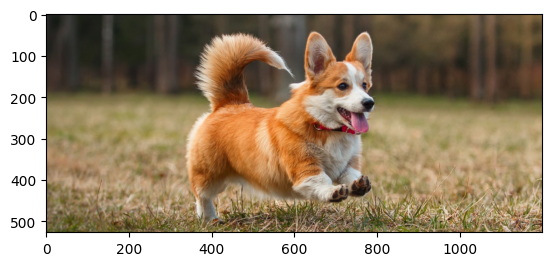

In [11]:
import requests
from PIL import Image

url = "https://github.com/CEA-LIST/neurocorgi_sdk/raw/master/neurocorgi_sdk/assets/corgi.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

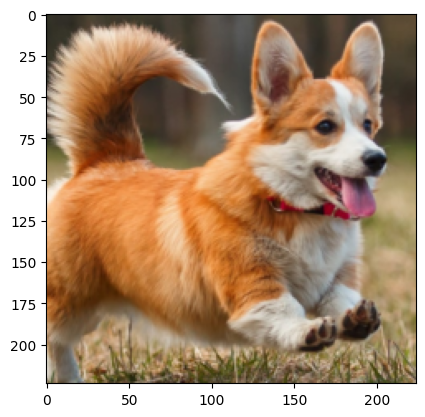

In [12]:
img = transform_val(img) 
plt.imshow(im_convert(img))

In [13]:
# Dog image expected label: 263: 'Pembroke, Pembroke Welsh corgi'
# See https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
image = img.to(device).unsqueeze(0)

# Inference
div4, div8, div16, div32 = model(image)
out = head(div32)
print(torch.topk(out.flatten(), 5))

torch.return_types.topk(
values=tensor([10.1303,  9.5345,  7.3861,  7.0032,  6.3148], grad_fn=<TopkBackward0>),
indices=tensor([263, 264, 157, 151, 253]))
